In [27]:
import torch
import torch.nn as nn

import numpy as np

import matplotlib.pyplot as plt

import word2vec
from data_loader import load_data

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

from utils import plot_confusion_matrix

import time

In [65]:
# class RNN_tc(nn.Module):
    
#     def __init__(self, input_size, hidden_size, output_size):
#         super(RNN_tc, self).__init__()
#         self.hidden_size = hidden_size
        
#         self.i2h = nn.Linear(input_size + hidden_size, hidden_size)
#         self.i2o = nn.Linear(input_size + hidden_size, output_size)
#         self.softmax = nn.LogSoftmax(dim=1)
        
#     def forward(self, input, hidden):
#         combined = torch.cat((input, hidden), 1)
#         hidden = self.i2h(combined)
#         output = self.i2o(combined)
#         output = self.softmax(output)
#         return output, hidden
    
#     def initHidden(self):
#         return torch.zeros(1, self.hidden_size)
        
class RNN_tc(nn.Module):
    
    def __init__(self, input_size, hidden_size, output_size):
        super(RNN_tc, self).__init__()
        self.hidden_size = hidden_size
        
        self.rnn = nn.RNNCell(input_size, hidden_size, nonlinearity='relu')
        self.i2o = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)
        
    def forward(self, input, hidden):
        hidden = self.rnn(input, hidden)
        output = self.i2o(hidden)
        output = self.softmax(output)
        return output, hidden
    
    def initHidden(self):
        return torch.zeros(1, self.hidden_size)
        


In [52]:
def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [53]:
dim_word2vec = 50
'../data/word2vec/glove.twitter.27B/word2vec.%dd.txt' % dim_word2vec

'../data/word2vec/glove.twitter.27B/word2vec.50d.txt'

In [54]:
# glov_wv = word2vec.load_wv('../data/word2vec/glove.twitter.27B/word2vec.%dd.txt' % dim_word2vec)
glov_wv = word2vec.load_model_with('../data/word2vec/retrained_word2vec/reddit_word2vec').wv

loading word2vec...


In [55]:
data, labels = load_data('../data/data.csv')
data_train, data_test, label_train, label_test = train_test_split(data, labels, test_size=0.2, shuffle=True,stratify=labels)

In [56]:
tmp = label_test.tolist()
for label in np.unique(label_test):
    print('{}: {}'.format(label, tmp.count(label)))

tmp2 = label_train.tolist()
for label in np.unique(label_train):
    print('{}: {}'.format(label, tmp2.count(label)))

education: 1016
politics: 1084
science: 1036
sports: 1000
education: 4065
politics: 4333
science: 4142
sports: 4000


In [57]:
def txt2vector(sentences, dic):
    vectors = []
    count = 0
    for sentence in sentences:
        vector = []
        for word in word2vec.preprocess(sentence[0]):
            if word in dic:
                vector.append(dic[word])
            else:
                count += 1
        vectors.append(vector)
#         assert False
        
    print('missing words: %d, avg missing words: %f' % (count, count / sentences.shape[0]))
    return vectors

In [58]:
data_train_vec = txt2vector(data_train, glov_wv)
data_test_vec = txt2vector(data_test, glov_wv)

missing words: 22515, avg missing words: 1.361245
missing words: 5777, avg missing words: 1.396760


In [59]:
all_categories = np.unique(labels).tolist()
all_categories

['education', 'politics', 'science', 'sports']

In [60]:
def label2vector(labels, all_categories):
    return [all_categories.index(label) for label in labels]

In [61]:
label_train_vec = label2vector(label_train, all_categories)
label_test_vec = label2vector(label_test, all_categories)

In [62]:
print(label_test_vec[0])

0


In [63]:
n_class = len(all_categories)
n_training = len(data_train)

epochs = 5
learning_rate = 1e-4
model_fn = '../results/rnn_tc/rnn_tc_50d.11150316.pt'

In [66]:
model = RNN_tc(dim_word2vec, 200, n_class)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
# scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
criterion = nn.NLLLoss()

losses = []

start = time.time()
min_loss = 1e+5

for epoch in range(epochs):
#     scheduler.step()
    
    for idx in range(n_training):
#     for idx in range(10000):
        hidden = model.initHidden()
        loss = 0
        
        X, y = torch.tensor(data_train_vec[idx]), torch.tensor([label_train_vec[idx]])

        n_samples = X.shape[0]
        for sample_idx in range(n_samples):
            output, hidden = model(X[sample_idx].reshape(1, -1), hidden)   
        
        loss = criterion(output, y)
        
        optimizer.zero_grad()
        loss.backward(retain_graph=True)
        
        optimizer.step()
        
        if loss < min_loss:
            min_loss = loss
            torch.save(model, model_fn)
        
        if idx % 100 == 0:
            losses.append(loss.item())
            print('%d epoch, %d index, %f loss' % (epoch, idx, loss.item()))

/Users/zhengcao/anaconda3/lib/python3.6/site-packages/torch/serialization.py:241: UserWarning: Couldn't retrieve source code for container of type RNN_tc. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


0 epoch, 0 index, 1.392009 loss
0 epoch, 100 index, 1.099318 loss
0 epoch, 200 index, 1.329733 loss
0 epoch, 300 index, 1.124416 loss
0 epoch, 400 index, 1.305866 loss
0 epoch, 500 index, 0.521760 loss
0 epoch, 600 index, 0.900426 loss
0 epoch, 700 index, 0.299371 loss
0 epoch, 800 index, 0.477470 loss
0 epoch, 900 index, 1.064383 loss
0 epoch, 1000 index, 0.231441 loss
0 epoch, 1100 index, 0.344939 loss
0 epoch, 1200 index, 0.004908 loss
0 epoch, 1300 index, 1.812173 loss
0 epoch, 1400 index, 0.003669 loss
0 epoch, 1500 index, 0.592863 loss
0 epoch, 1600 index, 0.709926 loss
0 epoch, 1700 index, 0.373781 loss
0 epoch, 1800 index, 1.106607 loss
0 epoch, 1900 index, 0.059403 loss
0 epoch, 2000 index, 0.143755 loss
0 epoch, 2100 index, 0.000021 loss
0 epoch, 2200 index, 0.082115 loss
0 epoch, 2300 index, 0.001035 loss
0 epoch, 2400 index, 1.012369 loss
0 epoch, 2500 index, 2.335396 loss
0 epoch, 2600 index, 2.229451 loss
0 epoch, 2700 index, 0.181147 loss
0 epoch, 2800 index, 0.682476 lo

1 epoch, 6700 index, 0.018160 loss
1 epoch, 6800 index, 0.006223 loss
1 epoch, 6900 index, 2.645361 loss
1 epoch, 7000 index, 0.234840 loss
1 epoch, 7100 index, 0.000618 loss
1 epoch, 7200 index, 0.000672 loss
1 epoch, 7300 index, 0.513021 loss
1 epoch, 7400 index, 0.194953 loss
1 epoch, 7500 index, 0.005408 loss
1 epoch, 7600 index, 0.071165 loss
1 epoch, 7700 index, 0.004172 loss
1 epoch, 7800 index, 0.004256 loss
1 epoch, 7900 index, 0.000862 loss
1 epoch, 8000 index, 0.000061 loss
1 epoch, 8100 index, 0.001146 loss
1 epoch, 8200 index, 0.001791 loss
1 epoch, 8300 index, 0.010934 loss
1 epoch, 8400 index, 0.048467 loss
1 epoch, 8500 index, 0.009803 loss
1 epoch, 8600 index, 0.011704 loss
1 epoch, 8700 index, 0.000088 loss
1 epoch, 8800 index, 0.167563 loss
1 epoch, 8900 index, 0.077967 loss
1 epoch, 9000 index, 2.243509 loss
1 epoch, 9100 index, 0.018340 loss
1 epoch, 9200 index, 0.004988 loss
1 epoch, 9300 index, 0.001356 loss
1 epoch, 9400 index, 0.753351 loss
1 epoch, 9500 index,

2 epoch, 13300 index, 0.006008 loss
2 epoch, 13400 index, 0.004953 loss
2 epoch, 13500 index, 0.800612 loss
2 epoch, 13600 index, 0.000000 loss
2 epoch, 13700 index, 0.409473 loss
2 epoch, 13800 index, 0.638195 loss
2 epoch, 13900 index, 0.000369 loss
2 epoch, 14000 index, 0.008861 loss
2 epoch, 14100 index, 2.278440 loss
2 epoch, 14200 index, 0.003197 loss
2 epoch, 14300 index, 0.237340 loss
2 epoch, 14400 index, 0.002090 loss
2 epoch, 14500 index, 0.001358 loss
2 epoch, 14600 index, 0.081606 loss
2 epoch, 14700 index, 0.017735 loss
2 epoch, 14800 index, 0.004727 loss
2 epoch, 14900 index, 0.005471 loss
2 epoch, 15000 index, 0.076737 loss
2 epoch, 15100 index, 0.003512 loss
2 epoch, 15200 index, 0.000035 loss
2 epoch, 15300 index, 0.000100 loss
2 epoch, 15400 index, 0.017543 loss
2 epoch, 15500 index, 0.000089 loss
2 epoch, 15600 index, 0.001698 loss
2 epoch, 15700 index, 5.044434 loss
2 epoch, 15800 index, 0.000005 loss
2 epoch, 15900 index, 0.000012 loss
2 epoch, 16000 index, 0.0017

4 epoch, 3300 index, 0.001721 loss
4 epoch, 3400 index, 0.121902 loss
4 epoch, 3500 index, 0.000782 loss
4 epoch, 3600 index, 0.010599 loss
4 epoch, 3700 index, 0.038371 loss
4 epoch, 3800 index, 0.002407 loss
4 epoch, 3900 index, 0.065439 loss
4 epoch, 4000 index, 2.550966 loss
4 epoch, 4100 index, 4.668782 loss
4 epoch, 4200 index, 0.001972 loss
4 epoch, 4300 index, 0.100015 loss
4 epoch, 4400 index, 0.017905 loss
4 epoch, 4500 index, 0.024737 loss
4 epoch, 4600 index, 0.005240 loss
4 epoch, 4700 index, 0.000001 loss
4 epoch, 4800 index, 0.000018 loss
4 epoch, 4900 index, 0.000728 loss
4 epoch, 5000 index, 0.000330 loss
4 epoch, 5100 index, 0.000212 loss
4 epoch, 5200 index, 0.026485 loss
4 epoch, 5300 index, 0.370997 loss
4 epoch, 5400 index, 0.003818 loss
4 epoch, 5500 index, 0.001966 loss
4 epoch, 5600 index, 0.010406 loss
4 epoch, 5700 index, 0.000426 loss
4 epoch, 5800 index, 0.036603 loss
4 epoch, 5900 index, 0.000099 loss
4 epoch, 6000 index, 0.000000 loss
4 epoch, 6100 index,

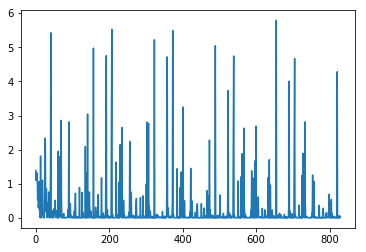

In [67]:
plt.figure()
plt.plot(np.arange(len(losses)), losses)
plt.show()

Confusion matrix, without normalization
[[ 848   65   57   46]
 [  11 1036    6   31]
 [  26   16  972   22]
 [   2   18    7  973]]


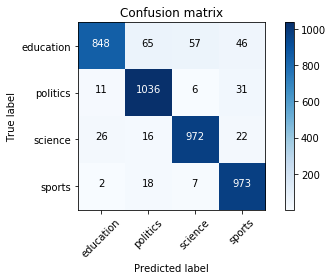

              precision    recall  f1-score   support

   education       0.96      0.83      0.89      1016
    politics       0.91      0.96      0.93      1084
     science       0.93      0.94      0.94      1036
      sports       0.91      0.97      0.94      1000

   micro avg       0.93      0.93      0.93      4136
   macro avg       0.93      0.93      0.92      4136
weighted avg       0.93      0.93      0.93      4136



In [68]:
def category_from_output(output, all_categories):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return all_categories[category_i]

def evaluate(model, sentence):
    hidden = model.initHidden()
    
    for sample_idx in range(sentence.shape[0]):
        output, hidden = model(sentence[sample_idx].reshape(1, -1), hidden)
    return output

n_test = len(data_test)
y_preds = []
for idx in range(n_test):
    X = torch.tensor(data_test_vec[idx])
    if X.shape[0] == 0:
        y_pred = torch.ones(n_class)
    else:
        y_pred = evaluate(model, X)
    y_preds.append(category_from_output(y_pred, all_categories))

cnf_matrix = confusion_matrix(label_test, y_preds)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=all_categories, title='Confusion matrix')
plt.show()

print(classification_report(label_test, y_preds))